In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Suppress Info,Warning

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, \
                    accuracy_score, roc_curve, auc

import matplotlib.pyplot as plt
%matplotlib inline

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#df_train = pd.read_csv('../data/train_cleaned.zip', compression='zip')
df_train = pd.read_csv('/content/drive/My Drive/train_cleaned.zip', compression='zip', engine='python')
df_train.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."


In [5]:
#df_test = pd.read_csv('../data/test_cleaned.zip', compression='zip')
df_test = pd.read_csv('/content/drive/My Drive/test_cleaned.zip', compression='zip', engine='python')
df_test.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxicity,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,thank you for understanding i think very highl...,"['thank', 'you', 'for', 'understanding', 'i', ...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highli', 'wo...","[('thank', 'NN'), ('understanding', 'VBG'), ('...","['thank', 'understanding', 'think', 'highly', ...","['thank', 'understand', 'think', 'highly', 'wo...","[('thank', 'understanding'), ('understanding',..."


In [6]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: str(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: str(x))

In [7]:
df_train['comment_text'][0], df_train['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [8]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [9]:
train_text = df_train.clean_text.values
test_text = df_test.clean_text.values

train_target = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
test_target = df_test[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

n_classes=train_target.shape[1]
max_words=75000
max_sequence_length=200
embedding_dims = 100

tokenizer = Tokenizer(num_words=max_words) 
tokenizer.fit_on_texts(np.concatenate([train_text, test_text]))

#Train
train_sequences = tokenizer.texts_to_sequences(train_text) 
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

#Test
test_sequences = tokenizer.texts_to_sequences(test_text) 
X_test = pad_sequences(test_sequences, maxlen=max_sequence_length)

word_index = tokenizer.word_index
embeddings_index = load_embedding("/content/drive/My Drive/glove.6B.100d.txt")
#embeddings_index = load_embedding("../glove.6B.50d.txt")
#embeddings_index = load_embedding("../glove.6B.100d.txt")

X_train, X_val, y_train, y_val = train_test_split(train_sequences, train_target, test_size=0.2, random_state=100)

In [10]:
filters=64
kernel_size=5

model = Sequential()
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dims))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model.add(Embedding(len(word_index) + 1,
                          embedding_dims,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,
                          trainable=True))

model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))

In [11]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          31100100  
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 64)            20544     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0

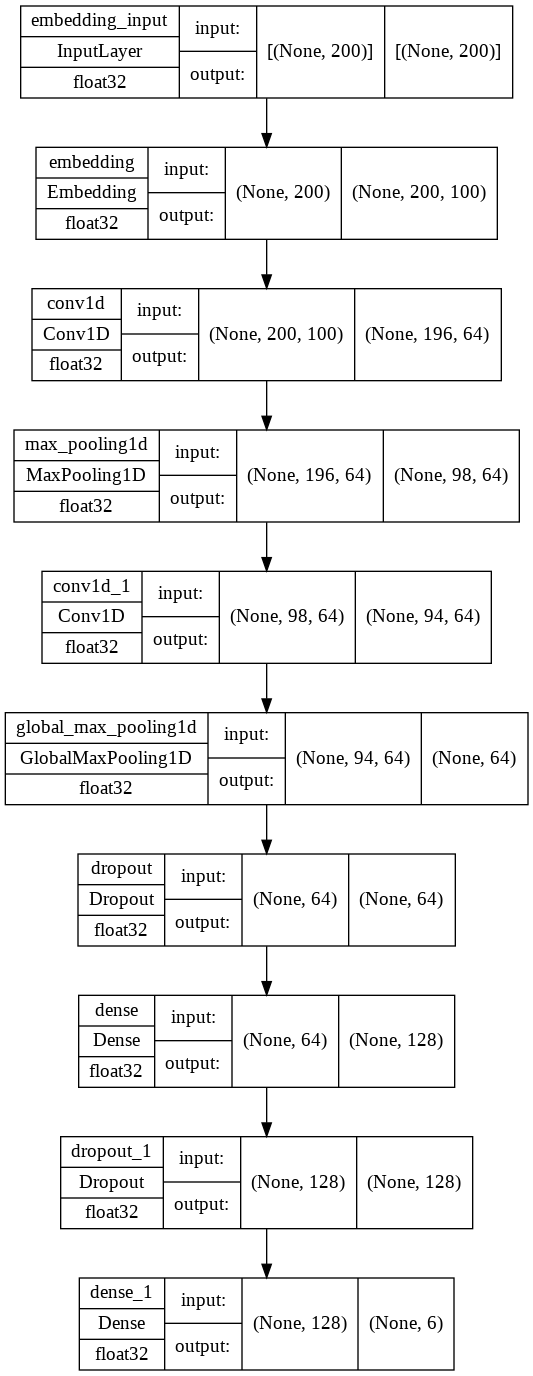

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [13]:
epochs = 20
batch_size=256

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size,
          epochs=epochs, callbacks=[es]
            )

Epoch 1/20
499/499 [==============================] - 42s 58ms/step - loss: 0.1072 - auc: 0.8956 - precision: 0.5977 - recall: 0.2918 - val_loss: 0.0565 - val_auc: 0.9751 - val_precision: 0.8085 - val_recall: 0.5890
Epoch 2/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0597 - auc: 0.9692 - precision: 0.7821 - recall: 0.6136 - val_loss: 0.0528 - val_auc: 0.9806 - val_precision: 0.8156 - val_recall: 0.6195
Epoch 3/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0517 - auc: 0.9784 - precision: 0.8040 - recall: 0.6549 - val_loss: 0.0519 - val_auc: 0.9800 - val_precision: 0.8368 - val_recall: 0.5905
Epoch 4/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0466 - auc: 0.9834 - precision: 0.8154 - recall: 0.6818 - val_loss: 0.0526 - val_auc: 0.9767 - val_precision: 0.8194 - val_recall: 0.6084
Epoch 5/20
499/499 [==============================] - 28s 56ms/step - loss: 0.0430 - auc: 0.9864 - precision: 0.8231 - recall: 0.7096 - 

In [14]:
history.history

{'auc': [0.8956121802330017,
  0.9691721796989441,
  0.9783768653869629,
  0.9833619594573975,
  0.9864155054092407,
  0.9888181686401367,
  0.9904492497444153,
  0.9919869899749756],
 'loss': [0.10720642656087875,
  0.05966857820749283,
  0.05166874825954437,
  0.04661037027835846,
  0.0429803803563118,
  0.0400080531835556,
  0.03749064356088638,
  0.03530513495206833],
 'precision': [0.5976802110671997,
  0.7820757031440735,
  0.8039618730545044,
  0.8154475092887878,
  0.8230724930763245,
  0.8324156999588013,
  0.8403337597846985,
  0.8484150171279907],
 'recall': [0.29184624552726746,
  0.6136144995689392,
  0.6548997163772583,
  0.6818295121192932,
  0.7095785737037659,
  0.7270330786705017,
  0.7461618185043335,
  0.7608022093772888],
 'val_auc': [0.9750604033470154,
  0.9806013703346252,
  0.9799537658691406,
  0.9767268896102905,
  0.9763363003730774,
  0.9663823843002319,
  0.9618344306945801,
  0.9565601348876953],
 'val_loss': [0.056508228182792664,
  0.052804913371801376,

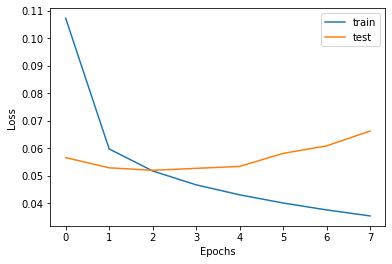

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

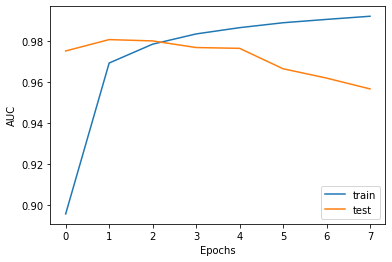

In [19]:
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

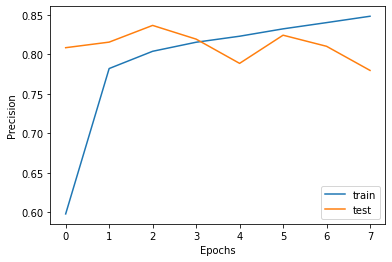

In [20]:
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

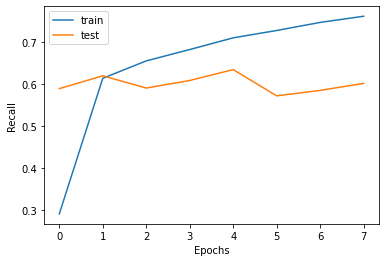

In [21]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [22]:
y_prob = model.predict(X_test)
y_pred = y_prob.round()

In [23]:
print(classification_report(test_target, y_pred))
multilabel_confusion_matrix(test_target, y_pred)

              precision    recall  f1-score   support

           0       0.50      0.85      0.63      6090
           1       0.00      0.00      0.00       367
           2       0.75      0.60      0.67      3691
           3       0.00      0.00      0.00       211
           4       0.67      0.49      0.56      3427
           5       0.00      0.00      0.00       712

   micro avg       0.58      0.63      0.60     14498
   macro avg       0.32      0.32      0.31     14498
weighted avg       0.56      0.63      0.57     14498
 samples avg       0.08      0.06      0.06     14498



array([[[52786,  5102],
        [  920,  5170]],

       [[63611,     0],
        [  367,     0]],

       [[59532,   755],
        [ 1470,  2221]],

       [[63767,     0],
        [  211,     0]],

       [[59710,   841],
        [ 1755,  1672]],

       [[63266,     0],
        [  712,     0]]])

In [24]:
print(f'Accuracy score: {accuracy_score(test_target, y_pred)}')

Accuracy score: 0.8573103254243646


In [25]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_target[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [26]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_target.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
print(roc_auc["micro"])

0.9671429519198675


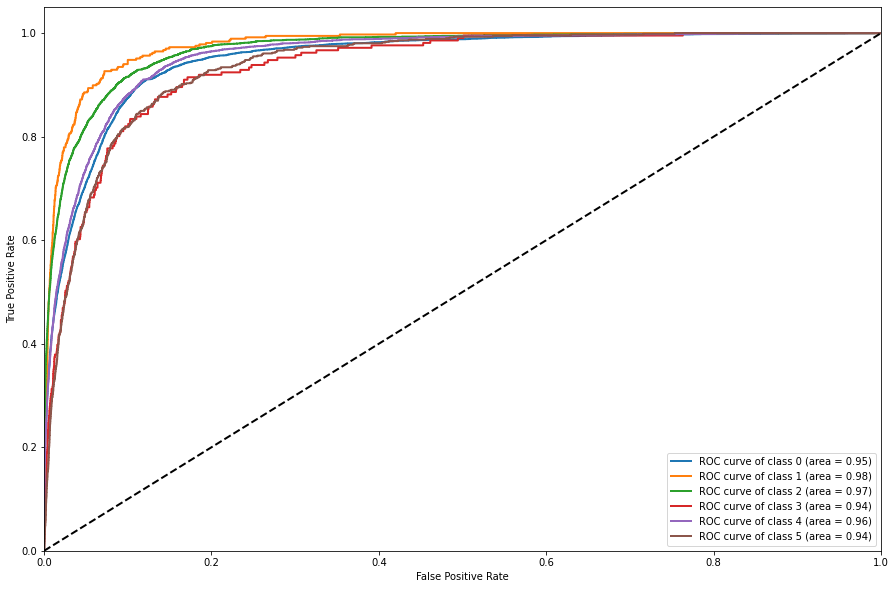

In [28]:
plt.figure(figsize=(15,10))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()